In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools as fct
import multiprocessing as mulpro
import pickle, joblib
import shutil, os
import time, gc

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

import sklearn as skl
import sklearn.model_selection
import sklearn.decomposition
import sklearn.linear_model
import sklearn.ensemble
import sklearn.pipeline
import sklearn.metrics

import cv2, PIL
import tensorflow as tf
import tensorflow.keras as tk
import tensorflow_datasets as tfds
import keras_tuner as kt
import tensorboard as tb

root = "/root/autodl-fs/Project"
path_model = "/root/autodl-fs/Project/Model"
path_cls = "/root/autodl-fs/Project/classification"
path_detect = "/root/autodl-fs/Project/detection"

## The EDA for the Classification Dataset
### 1. Some basic statistical information

In [2]:
def find_files(directory, extension):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_paths.append(os.path.join(root, file))
    return file_paths

# Use the function to find all .jpg files in the 'main_directory'
image_paths = find_files(path_cls, ".jpg")
class_dict_origin = dict(zip(image_paths, list(map(lambda x: str(x.split("/")[-2]), image_paths))))

def image_info(image_path):
    label = str(image_path.split("/")[-2])
    height, width, _ = cv2.imread(image_path).shape
    return [height, width, label]

# Count the height, width, and class information for all the images
with mulpro.Pool(processes=24) as pool:
    image_infos = pool.map(image_info, image_paths)
image_infos = pd.DataFrame(image_infos, columns=["width", "height", "class"])

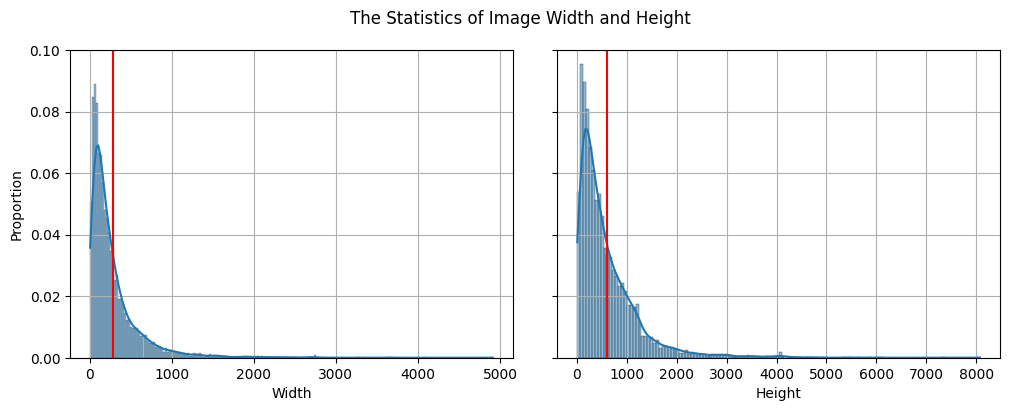

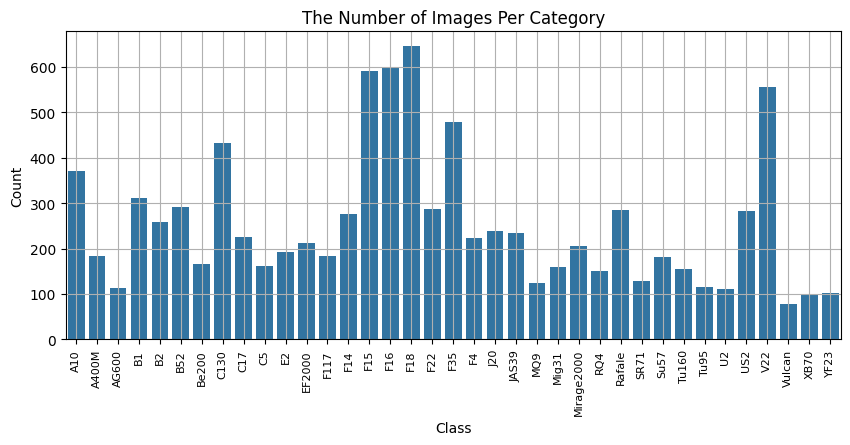

In [3]:
# Visualize the distribution of images' width and height separately
image_shape = ["width", "height"]
figs, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(wspace=0.1, hspace=0), sharey=True)
plt.suptitle("The Statistics of Image Width and Height")
for i, ax in enumerate(axes.flat):
    sns.histplot(image_infos, x=image_shape[i], stat="proportion", kde=True, ax=ax)
    ax.axvline(x = np.mean(image_infos[image_shape[i]]), color = 'red')
    ax.set_xlabel(image_shape[i].capitalize()); ax.grid()
plt.show()

# Count and visualize the number of images for each class
class_amount = image_infos.value_counts(subset="class").\
    sort_index(ascending=True).reset_index(drop=False)
plt.figure(figsize=(10, 4)); ax=plt.axes()
sns.barplot(class_amount, x="class", y="count", ax=ax)
plt.xticks(rotation=90, size=8)
plt.xlabel("Class"); plt.ylabel("Count")
plt.title("The Number of Images Per Category")
plt.grid(); plt.show()

desired_class = list(class_amount.loc[class_amount["count"]>=100, "class"])
path_cls_dict = {key: value for (key, value) in class_dict_origin.items() if value in desired_class}
num_cls_dict = dict(zip(range(len(desired_class)), desired_class))

In [ ]:
# Record the paths of the images for each category
image_paths_classes = {}
for image_path in path_cls_dict.keys():
    label = str(image_path.split("/")[-2])
    if label not in image_paths_classes:
        image_paths_classes[label] = list()
    image_paths_classes[label].append(image_path)

# Extract an image from each category
selected_image_paths = []
for label, paths in image_paths_classes.items():
    selected_image_path = paths[np.random.choice(len(paths))]
    selected_image_paths.append([label, selected_image_path])
selected_image_paths = pd.DataFrame(selected_image_paths, columns=["label", "image_path"]).\
    sort_values(by="label", ascending=True, axis=0).reset_index(drop=True)

# Visualize the extracted 36 images (one image for each class)
num_images = len(selected_image_paths); cols=4; rows=(num_images//cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.suptitle("The Photo Display for Each Aircraft", size=18, y=0.88)
for ax, (label, image_path) in zip(axes.flat[:num_images], selected_image_paths.values):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image); ax.axis("off")
    ax.set_title(f"Class: {label}")
plt.show()

### 2. Image data preprocessing operations
#### (1) Image resizing

In [ ]:
def resize_image_cv2(image):
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return resized_image

# Visualize the extracted 36 images after Resizing
num_images = len(selected_image_paths); cols=4; rows=(num_images//cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.suptitle("The Photo Display for Each Aircraft", size=18, y=0.9)
for ax, (label, image_path) in zip(axes.flat[:num_images], selected_image_paths.values):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    resized_image = resize_image_cv2(image)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    ax.imshow(resized_image); ax.axis("off")
    ax.set_title(f"Class: {label}")
plt.show()

#### (2) Adaptive histogram equalization

In [ ]:
def CLAHE_image_cv2(image):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # 将图像从BGR转换到YCrCb色彩空间
    y, cr, cb = cv2.split(ycrcb_image) # 分离YCrCb通道
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # 创建CLAHE对象
    equalized_y = clahe.apply(y) # 对亮度通道应用CLAHE
    equalized_ycrcb = cv2.merge([equalized_y, cr, cb]) # 合并通道
    equalized_color_image = cv2.cvtColor(equalized_ycrcb, cv2.COLOR_YCrCb2BGR) # 将结果从YCrCb转换回BGR色彩空间
    return equalized_color_image

# Visualize the extracted 36 images after Adaptive Histogram Equalization
num_images = len(selected_image_paths); cols=4; rows=(num_images//cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.suptitle("The Photo Display for Each Aircraft", size=18, y=0.9)
for ax, (label, image_path) in zip(axes.flat[:num_images], selected_image_paths.values):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR) # 读取彩色图像
    resized_image = resize_image_cv2(image)
    equalized_color_image = CLAHE_image_cv2(resized_image)
    equalized_color_image = cv2.cvtColor(equalized_color_image, cv2.COLOR_BGR2RGB)
    ax.imshow(equalized_color_image); ax.axis("off")
    ax.set_title(f"Class: {label}")
plt.show()

#### (3) Bilateral Filtering

In [ ]:
def bilateral_filter_cv2(image):
   # 应用双边滤波，可以调整双边滤波的参数：d, sigmaColor, sigmaSpace
    bilateral_filtered_image = cv2.bilateralFilter(image, d=6, sigmaColor=25, sigmaSpace=25) 
    return bilateral_filtered_image

# Visualize the extracted 36 images after Bilateral Filtering
num_images = len(selected_image_paths); cols=4; rows=(num_images//cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.suptitle("The Photo Display for Each Aircraft", size=18, y=0.9)
for ax, (label, image_path) in zip(axes.flat[:num_images], selected_image_paths.values):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR) # 读取彩色图像
    resized_image = resize_image_cv2(image)
    equalized_color_image = CLAHE_image_cv2(resized_image)
    bilateral_filtered_image = bilateral_filter_cv2(equalized_color_image)
    bilateral_filtered_image = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2RGB)
    ax.imshow(bilateral_filtered_image); ax.axis("off")
    ax.set_title(f"Class: {label}")
plt.show()

In [ ]:
def resize_image(image, size=(224, 224)):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    return resized_image

def CLAHE_image(image, clipLimit=2.0, tileGridSize=(8, 8)):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # 将图像从BGR转换到YCrCb色彩空间
    y, cr, cb = cv2.split(ycrcb_image) # 分离YCrCb通道
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize) # 创建CLAHE对象
    equalized_y = clahe.apply(y) # 对亮度通道应用CLAHE
    equalized_ycrcb = cv2.merge([equalized_y, cr, cb]) # 合并通道
    equalized_color_image = cv2.cvtColor(equalized_ycrcb, cv2.COLOR_YCrCb2BGR) # 将结果从YCrCb转换回BGR色彩空间
    return equalized_color_image

def bilateral_filter(image, d=6, sigmaColor=25, sigmaSpace=25):
   # 应用双边滤波，可以调整双边滤波的参数：d, sigmaColor, sigmaSpace
    bilateral_filtered_image = cv2.bilateralFilter(
        image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace) 
    return bilateral_filtered_image

def processing_pipeline(image, size=(224, 224),
    clipLimit=2.0, tileGridSize=(8, 8), d=6, sigmaColor=25, sigmaSpace=25):
    resized_image = resize_image(image, size=size)
    clahe_image = CLAHE_image(resized_image, clipLimit=clipLimit, tileGridSize=tileGridSize)
    bilateral_image = bilateral_filter(clahe_image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    return bilateral_image

image = resize_image(cv2.imread(selected_image_paths.image_path[35]))
processing_image = processing_pipeline(cv2.imread(selected_image_paths.image_path[35]))
processing_image2 = processing_pipeline(cv2.imread(selected_image_paths.image_path[35]),tileGridSize=(14,14))

# 使用matplotlib显示原图像和滤波后的图像
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image (Resizing)'); plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processing_image, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.axis('off'); plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(processing_image2, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.axis('off'); plt.show()

### 3. Composite preprocessing for each image

In [49]:
# !cp -r /root/autodl-fs/Project/classification /root/autodl-fs/Project/clsftn_modify
# !rm -rf /root/autodl-fs/Project/clsftn_modify/Vulcan

In [63]:
def find_files(directory, extension):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_paths.append(os.path.join(root, file))
    return file_paths

path_cls = "/root/autodl-fs/Project/clsftn_modify"
# Use the function to find all .jpg files in the 'main_directory'
image_paths = find_files(path_cls, ".jpg")

with open(os.path.join(root, "image_paths.pkl"), "wb") as f:
    pickle.dump(image_paths, f)

In [ ]:
def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    processed_image = processing_pipeline(image)
    cv2.imwrite(image_path, processed_image)
    image_name = image_path.split("/")[-1]
    print(f'Processed {image_name}')

with open(os.path.join(root, "image_paths.pkl"), "rb") as f:
    image_paths = pickle.load(f)

# 使用多进程进行图像处理
if __name__ == '__main__':
    with mulpro.Pool(processes=28) as pool:
        pool.map(process_image, image_paths)

### 4. Dataset shuffle and train, validation, test split

In [44]:
with open(os.path.join(root, "image_paths.pkl"), "rb") as f:
    image_paths = pickle.load(f)

def image_match(image_path):
    label = str(image_path.split("/")[-2])
    #height, width, _ = cv2.imread(image_path).shape
    #return [image_path, height, width, label]
    return [image_path, label]

with mulpro.Pool(processes=28) as pool:
    image_matches = pool.map(image_match, image_paths)
image_matches = pd.DataFrame(image_matches, columns = ["path", "label"]).\
    sort_values(by="label", ascending=True, axis=0).reset_index(drop=True)
image_matches = image_matches.sample(frac=1.0, replace=False, random_state=42, axis=0, ignore_index=True)

trainValSet, testSet = skl.model_selection.train_test_split(
    image_matches, test_size=0.15, random_state=60, shuffle=True, stratify=image_matches.label)
trainSet, valSet = skl.model_selection.train_test_split(
    trainValSet, test_size=(3/17), random_state=100, shuffle=True, stratify=trainValSet.label)

In [ ]:
path_cls = "/root/autodl-fs/Project/clsftn_modify"
for name, Set in zip(["train", "val", "test"], [trainSet, valSet, testSet]):
    for source_path, label in Set.values:
        image_name = source_path.strip().split("/")[-1]
        destination_path = os.path.join(path_cls, name, label, image_name)
        destination_dir = os.path.dirname(destination_path)
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir, exist_ok=True)
        shutil.move(source_path, destination_path)

# Classes = image_matches.label.unique()
# for cls in Classes:
#     os.system(f"rm -rf /root/autodl-fs/Project/clsftn_modify/{cls}")

# !zip -rq clsftn_modify.zip /root/autodl-fs/Project/clsftn_modify

### 5. Data augmentation process

In [ ]:
data_augmentation = tk.Sequential([
    tk.layers.RandomFlip("horizontal"),
    tk.layers.RandomRotation(0.1),
    tk.layers.RandomZoom(0.2),])

## The EDA for the Object Detection Dataset
### 1. Some basic statistical information

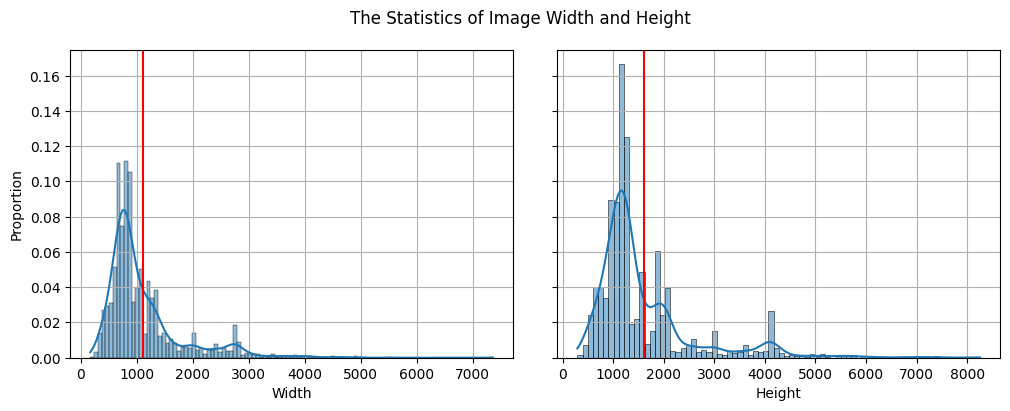

In [4]:
all_files = os.listdir(path_detect)
image_paths = list(filter(lambda x: ".jpg" in x, all_files))
image_paths = list(map(lambda x: os.path.join(path_detect, x), image_paths))
label_paths = list(filter(lambda x: ".csv" in x, all_files))
label_paths = list(map(lambda x: os.path.join(path_detect, x), label_paths))

def image_info(image_path):
    height, width, _ = cv2.imread(image_path).shape
    return [height, width]

with mulpro.Pool(processes=28) as pool:
    image_infos = pool.map(image_info, image_paths)
image_infos = pd.DataFrame(image_infos, columns=["width", "height"])

# Visualize the distribution of images' width and height separately
image_shape = ["width", "height"]
figs, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(wspace=0.1, hspace=0), sharey=True)
plt.suptitle("The Statistics of Image Width and Height")
for i, ax in enumerate(axes.flat):
    sns.histplot(image_infos, x=image_shape[i], stat="proportion", kde=True, ax=ax)
    ax.axvline(x = np.mean(image_infos[image_shape[i]]), color = 'red')
    ax.set_xlabel(image_shape[i].capitalize()); ax.grid()
plt.show()

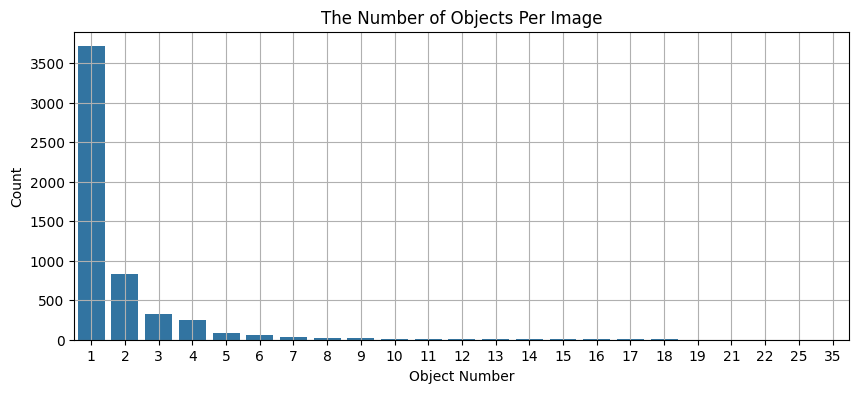

In [51]:
columns = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]
label_df = pd.DataFrame(columns=columns)
for csv_file in label_paths:
    label_temp = pd.read_csv(csv_file, header=0)
    label_df = pd.concat([label_df, label_temp], axis=0, ignore_index=True)
label_df = label_df.sort_values(by="filename", ascending=True, axis=0).reset_index(drop=True)

label_df["num"] = label_df.groupby("filename", group_keys=False)["class"].transform(lambda x: len(x))
image_match = label_df[["filename", "num"]].drop_duplicates(subset="filename", ignore_index=True)
label_count = image_match.value_counts(subset="num").sort_index(ascending=True).reset_index(drop=False)
plt.figure(figsize=(10, 4)); ax=plt.axes()
sns.barplot(label_count, x="num", y="count", ax=ax)
plt.xlabel("Object Number"); plt.ylabel("Count")
plt.title("The Number of Objects Per Image")
plt.grid(); plt.show()

### 2. Hyperparameter tuning and processing on each image

In [3]:
# !cp -r /root/autodl-fs/Project/detection /root/autodl-fs/Project/det_modify

In [ ]:
def resize_image(image, size=(640, 640)):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    return resized_image

def CLAHE_image(image, clipLimit=2.0, tileGridSize=(14, 14)):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # 将图像从BGR转换到YCrCb色彩空间
    y, cr, cb = cv2.split(ycrcb_image) # 分离YCrCb通道
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize) # 创建CLAHE对象
    equalized_y = clahe.apply(y) # 对亮度通道应用CLAHE
    equalized_ycrcb = cv2.merge([equalized_y, cr, cb]) # 合并通道
    equalized_color_image = cv2.cvtColor(equalized_ycrcb, cv2.COLOR_YCrCb2BGR) # 将结果从YCrCb转换回BGR色彩空间
    return equalized_color_image

def bilateral_filter(image, d=6, sigmaColor=25, sigmaSpace=25):
   # 应用双边滤波，可以调整双边滤波的参数：d, sigmaColor, sigmaSpace
    bilateral_filtered_image = cv2.bilateralFilter(
        image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace) 
    return bilateral_filtered_image

def processing_pipeline(image, size=(640, 640),
    clipLimit=2.0, tileGridSize=(14, 14), d=6, sigmaColor=25, sigmaSpace=25):
    resized_image = resize_image(image, size=size)
    clahe_image = CLAHE_image(resized_image, clipLimit=clipLimit, tileGridSize=tileGridSize)
    bilateral_image = bilateral_filter(clahe_image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    return bilateral_image

N=3; selected_image_paths = image_paths[1000:1000+N]
figs, axes = plt.subplots(len(selected_image_paths), 2,
    figsize=(10, 4*len(selected_image_paths)), gridspec_kw=dict(wspace=0.1, hspace=0.1))
for i, (ax_0, ax_1) in enumerate(axes):
    image = resize_image(cv2.imread(selected_image_paths[i]))
    processed_image = processing_pipeline(cv2.imread(selected_image_paths[i]))
    ax_0.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax_0.set_title("Original Image (Resizing)"); ax_0.axis("off")
    ax_1.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    ax_1.set_title("Preprocessed Image"); ax_1.axis("off")

In [11]:
def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    processed_image = processing_pipeline(image)
    cv2.imwrite(image_path, processed_image)
    label_path = image_path.replace(".jpg", ".csv")
    img_lab = pd.read_csv(label_path, header=0)
    img_lab["num"] = len(img_lab)
    img_lab[["xmin_r", "xmax_r"]] = img_lab[["xmin", "xmax"]].values/img_lab[["width"]].values
    img_lab[["ymin_r", "ymax_r"]] = img_lab[["ymin", "ymax"]].values/img_lab[["height"]].values
    img_lab.to_csv(label_path, header=True, index=False)
    # image_name = image_path.split("/")[-1]
    # print(f'Processed {image_name}')

path_detect = "/root/autodl-fs/Project/det_modify"
all_files = os.listdir(path_detect)
image_paths = list(filter(lambda x: ".jpg" in x, all_files))
image_paths = list(map(lambda x: os.path.join(path_detect, x), image_paths))
label_paths = list(filter(lambda x: ".csv" in x, all_files))
label_paths = list(map(lambda x: os.path.join(path_detect, x), label_paths))

# with mulpro.Pool(processes=28) as pool:
#     pool.map(process_image, image_paths)

### 3. Dataset shuffle and train, validation, test split

In [12]:
columns = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax",
           "num", "xmin_r", "ymin_r", "xmax_r", "ymax_r"]
labels_df = pd.DataFrame(columns=columns)
for csv_file in label_paths:
    label_temp = pd.read_csv(csv_file, header=0)
    labels_df = pd.concat([labels_df, label_temp], axis=0, ignore_index=True)
labels_df = labels_df.sort_values(by="filename", ascending=True, axis=0).reset_index(drop=True)

image_matches = labels_df[["filename", "num"]].drop_duplicates(subset="filename", ignore_index=True)
label_count = image_matches.value_counts(subset="num").sort_index(ascending=True).reset_index(drop=False)
num_remove = list(label_count.loc[label_count["count"]<20].num)
images_remove = image_matches.loc[image_matches.num.isin(num_remove)]
images_desire = image_matches.loc[~image_matches.num.isin(num_remove)]
images_desire = images_desire.sample(frac=1.0, replace=False, random_state=66, axis=0, ignore_index=True)

trainValSet, testSet = skl.model_selection.train_test_split(
    images_desire, test_size=0.15, random_state=90, shuffle=True, stratify=images_desire.num)
trainSet, valSet = skl.model_selection.train_test_split(
    trainValSet, test_size=(3/17), random_state=120, shuffle=True, stratify=trainValSet.num)

In [24]:
path_detect = "/root/autodl-fs/Project/det_modify"
# for name, Set in zip(["train", "val", "test"], [trainSet, valSet, testSet]):
#     for image_name in Set.filename:
#         source_path = os.path.join(path_detect, image_name+".jpg")
#         destination_path = os.path.join(path_detect, name, image_name+".jpg")
#         lab_source_path = source_path.replace(".jpg", ".csv")
#         lab_destination_path = destination_path.replace(".jpg", ".csv")
#         destination_dir = os.path.dirname(destination_path)
#         if not os.path.exists(destination_dir):
#             os.makedirs(destination_dir, exist_ok=True)
#         shutil.move(source_path, destination_path)
#         shutil.move(lab_source_path, lab_destination_path)

# for image_name in images_remove.filename:
#     image_path = os.path.join(path_detect, image_name+".jpg")
#     lab_path = image_path.replace(".jpg", ".csv")
#     os.system(f"rm -rf {image_path}")
#     os.system(f"rm -rf {lab_path}")

!zip -rq det_modify.zip det_modify

In [21]:
label_df = labels_df.loc[labels_df.filename.isin(list(images_desire.filename))].\
    sort_values(by="filename", ascending=True, axis=0).reset_index(drop=True)
with open(os.path.join(path_detect, "label_df.pkl"), "wb") as f:
    pickle.dump(label_df, f)

label_train_df = label_df.loc[label_df.filename.isin(list(trainSet.filename))].\
    sort_values(by="filename", ascending=True, axis=0).reset_index(drop=True)
with open(os.path.join(path_detect, "label_train_df.pkl"), "wb") as f:
    pickle.dump(label_train_df, f)

label_val_df = label_df.loc[label_df.filename.isin(list(valSet.filename))].\
    sort_values(by="filename", ascending=True, axis=0).reset_index(drop=True)
with open(os.path.join(path_detect, "label_val_df.pkl"), "wb") as f:
    pickle.dump(label_val_df, f)

label_test_df = label_df.loc[label_df.filename.isin(list(testSet.filename))].\
    sort_values(by="filename", ascending=True, axis=0).reset_index(drop=True)
with open(os.path.join(path_detect, "label_test_df.pkl"), "wb") as f:
    pickle.dump(label_test_df, f)